In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap


/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data


In [2]:


# Path of the file to read
iowa_file_path = 'train.csv'

# Fill in the line below to read the file into a variable home_data
home_data = pd.read_csv(iowa_file_path)



##  Review The Data


In [5]:
home_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
# What is the average lot size (rounded to nearest integer)?
avg_lot_size = round(home_data['LotArea'].mean())


# As of today, how old is the newest home (current year - the date in which it was built)
newest_home_age = round(2024-home_data['YearBuilt'].max())
print(avg_lot_size, newest_home_age)


10517 14


In [4]:
# Create target object and call it y
y = home_data.SalePrice
# Create X
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = home_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Specify Model
iowa_model = DecisionTreeRegressor(random_state=1)
# Fit Model
iowa_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.0f}".format(val_mae))


Validation MAE: 29,653


In [5]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

## Compare Different Tree Sizes
Write a loop that tries the following values for *max_leaf_nodes* from a set of possible values.

Call the *get_mae* function on each value of max_leaf_nodes. Store the output in some way that allows you to select the value of `max_leaf_nodes` that gives the most accurate model on your data.  A deep tree with lots of leaves will overfit because each prediction is coming from historical data from only the few houses at its leaf. But a shallow tree with few leaves will perform poorly because it fails to capture as many distinctions in the raw data.

In [6]:
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for max_leaf_nodes in candidate_max_leaf_nodes:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = 100
print(best_tree_size)

Max leaf nodes: 5  		 Mean Absolute Error:  35044
Max leaf nodes: 25  		 Mean Absolute Error:  29016
Max leaf nodes: 50  		 Mean Absolute Error:  27405
Max leaf nodes: 100  		 Mean Absolute Error:  27282
Max leaf nodes: 250  		 Mean Absolute Error:  27893
Max leaf nodes: 500  		 Mean Absolute Error:  29454
100


## Fit Model Using All Data
You know the best tree size. If you were going to deploy this model in practice, you would make it even more accurate by using all of the data and keeping that tree size.  That is, you don't need to hold out the validation data now that you've made all your modeling decisions.

In [7]:
# Fill in argument to make optimal size and uncomment
final_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=0)

# fit the final model and uncomment the next two lines
final_model.fit(X, y)


DecisionTreeRegressor(max_leaf_nodes=100, random_state=0)

## Using a Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1)

# fit your model
rf_model.fit(train_X, train_y)

# Calculate the mean absolute error of your Random Forest model on the validation data
preds = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(val_y, preds)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

Validation MAE for Random Forest Model: 21857.15912981083


In [9]:
# To improve accuracy, create a new Random Forest model which you will train on all training data
rf_model_on_full_data = RandomForestRegressor(random_state=1)

# fit rf_model_on_full_data on all data from the training data
rf_model_on_full_data.fit(X, y)

RandomForestRegressor(random_state=1)

Now, read the file of "test" data, and apply your model to make predictions.


In [10]:
# path to file you will use for predictions
test_data_path = 'test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

# create test_X which comes from test_data but includes only the columns you used for prediction.
# The list of columns is stored in a variable called features
test_X = test_data[features]

# make predictions which we will submit. 
test_preds = rf_model_on_full_data.predict(test_X)

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission_houses.csv', index=False)

print(output.head())

     Id  SalePrice
0  1461  122656.58
1  1462  156789.00
2  1463  182959.00
3  1464  178102.00
4  1465  189049.48


# Importancia de las características 
 feature_importances_ da acceso a los pesos o importancia de cada característica en el modelo de árbol de decisión
  Las características que se usan con más frecuencia y tienen más influencia
 en las divisiones del árbol obtienen un mayor valor de importancia.
 El modelo mide la importancia de cada característica basándose en cuántas veces y qué tan temprano en el árbol 
 se utiliza esa característica para hacer una división. 
 También considera la reducción en la impureza (como el error o la varianza) que cada división logra. 
 Luego normaliza estos valores para que la suma de todas las importancias sea 1 (o 100%).

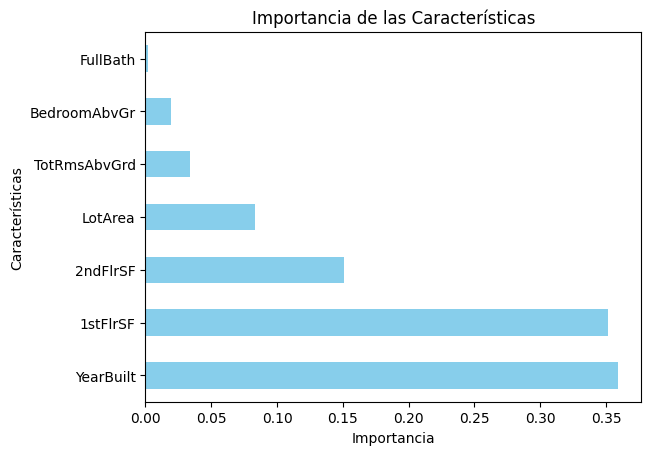

In [11]:


importances = iowa_model.feature_importances_
# Crear un DataFrame para facilitar la visualización
feat_importances = pd.Series(importances, index=features)
feat_importances.nlargest(7).plot(kind='barh', color='skyblue')
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

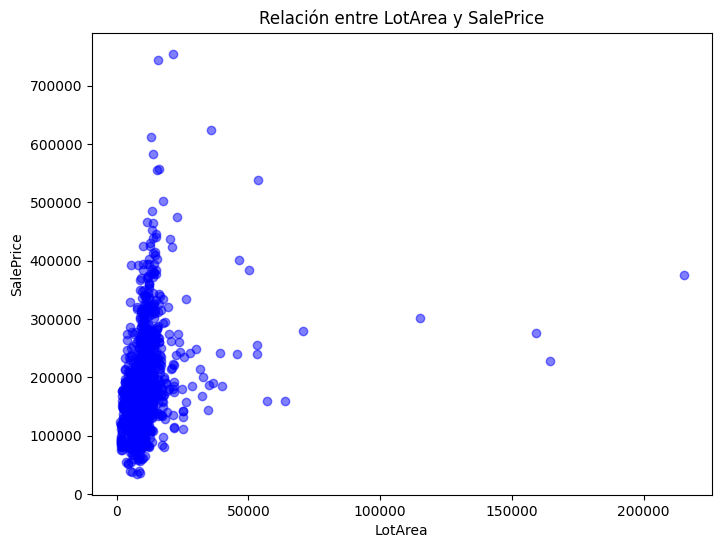

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(X['LotArea'], y, color='blue', alpha=0.5)
plt.title('Relación entre LotArea y SalePrice')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.show()

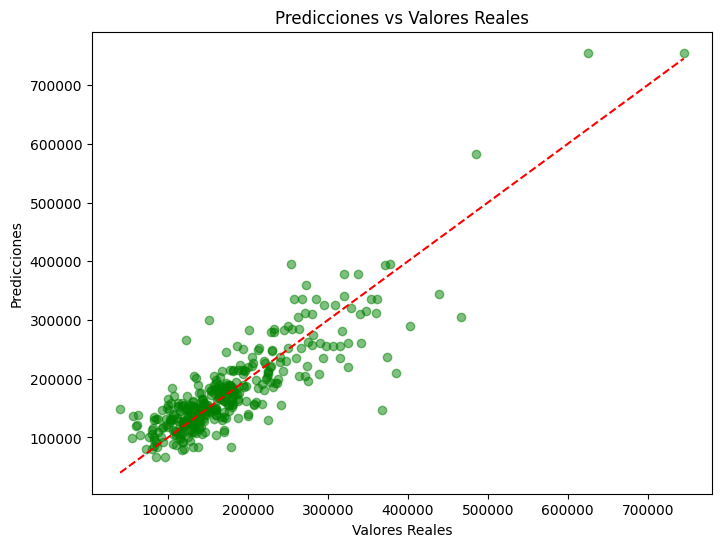

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(val_y, val_predictions, alpha=0.5, color='green')
plt.plot([min(val_y), max(val_y)], [min(val_y), max(val_y)], color='red', linestyle='--')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

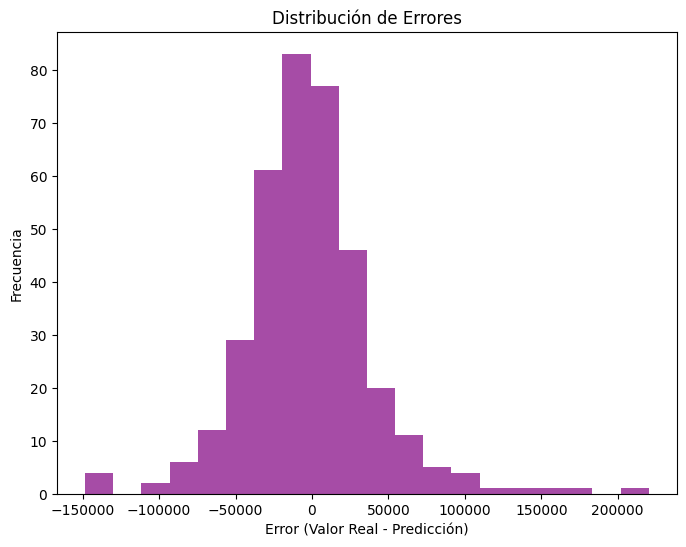

In [14]:
errors = val_y - val_predictions
plt.figure(figsize=(8,6))
plt.hist(errors, bins=20, color='purple', alpha=0.7)
plt.title('Distribución de Errores')
plt.xlabel('Error (Valor Real - Predicción)')
plt.ylabel('Frecuencia')
plt.show()

# Ntiles
Ntiles (o cuantiles), puedes dividir las predicciones o los valores reales en grupos de percentiles. Esto te ayudará a visualizar la distribución de los datos en grupos de tamaño igual, donde cada "Ntile" representa un rango específico de valores. Por ejemplo, podrías agrupar las casas en 10 grupos (deciles) o 4 grupos (cuartiles).
El gráfico Ntile es una excelente manera de evaluar cómo el modelo predice en diferentes segmentos de precios, identificando errores sistemáticos y ayudando a guiar ajustes futuros para mejorar el rendimiento del modelo.

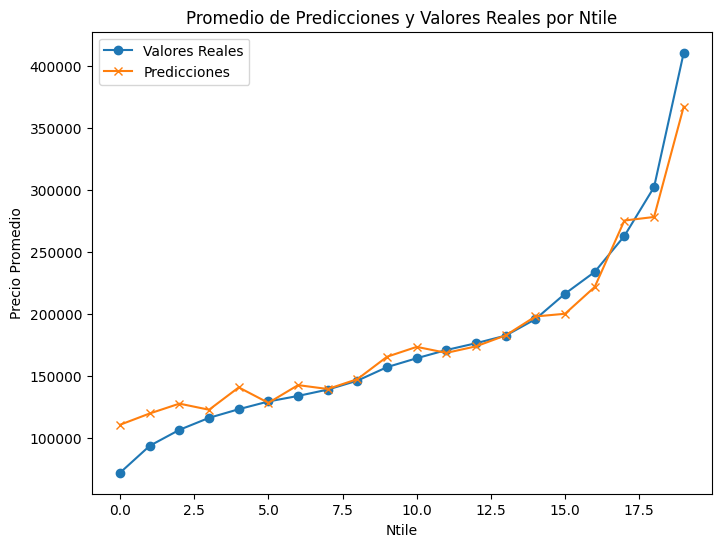

In [15]:
# Crear deciles (10 ntiles) para los valores reales
val_y_ntiles = pd.qcut(val_y, q=20, labels=False)

# Calcular el promedio de predicciones en cada decil
ntile_groups = pd.DataFrame({'Real': val_y, 'Predicciones': val_predictions, 'Ntile': val_y_ntiles})
ntile_means = ntile_groups.groupby('Ntile').mean()

# Graficar
plt.figure(figsize=(8,6))
plt.plot(ntile_means.index, ntile_means['Real'], label='Valores Reales', marker='o')
plt.plot(ntile_means.index, ntile_means['Predicciones'], label='Predicciones', marker='x')
plt.title('Promedio de Predicciones y Valores Reales por Ntile')
plt.xlabel('Ntile')
plt.ylabel('Precio Promedio')
plt.legend()
plt.show()

# Crear un gráfico de Ntiles basado en el error absoluto
Una alternativa interesante para evaluar el rendimiento de tu modelo de regresión sería agrupar las predicciones en Ntiles y observar cómo varía el error absoluto (diferencia entre las predicciones y los valores reales) en cada Ntile. Esto te permitiría ver en qué rangos el modelo tiende a ser más preciso o menos preciso.

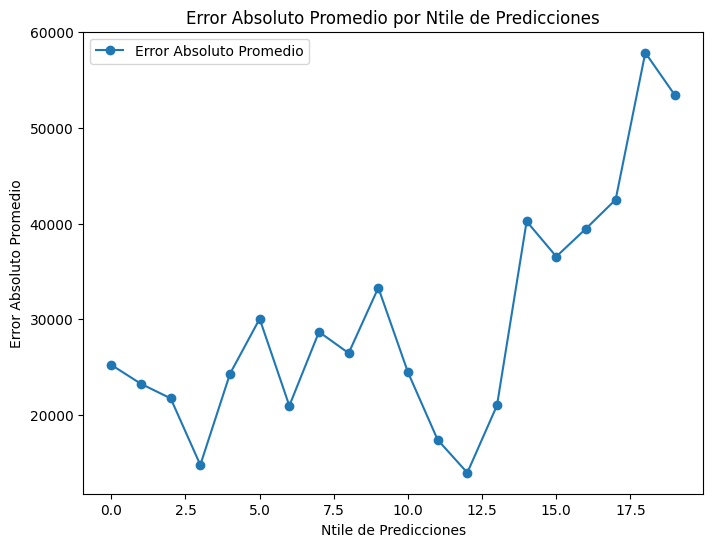

In [16]:
# Calcular las predicciones del modelo
val_predictions = iowa_model.predict(val_X)

# Calcular el error absoluto
abs_errors = np.abs(val_predictions - val_y)

# Dividir las predicciones en 10 Ntiles
val_y_ntiles = pd.qcut(val_predictions, q=20, labels=False)

# Crear un DataFrame con las predicciones, los valores reales y el error absoluto
ntile_groups = pd.DataFrame({'Predicciones': val_predictions, 'Valores Reales': val_y, 'Error Absoluto': abs_errors, 'Ntile': val_y_ntiles})

# Calcular el error absoluto promedio en cada Ntile
ntile_mean_errors = ntile_groups.groupby('Ntile').mean()

# Graficar el error absoluto promedio por Ntile
plt.figure(figsize=(8,6))
plt.plot(ntile_mean_errors.index, ntile_mean_errors['Error Absoluto'], label='Error Absoluto Promedio', marker='o')
plt.title('Error Absoluto Promedio por Ntile de Predicciones')
plt.xlabel('Ntile de Predicciones')
plt.ylabel('Error Absoluto Promedio')
plt.legend()
plt.show()

# Uso de LIME (Local Interpretable Model-agnostic Explanations)
para interpretar localmente los resultados del modelo de Machine Learning. LIME ayuda a entender qué características están influenciando una predicción específica, y cómo cada característica contribuye al valor predicho por el modelo.

In [18]:
# objeto explicador LIME.
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_X),
    feature_names=features,  # Lista de las características que estás usando
    mode='regression'
)

In [19]:
# Seleccionar una muestra específica de las casas para la que quieres la explicación
i = 0  # Primer índice, puedes cambiar esto para analizar otras casas
exp = explainer.explain_instance(
    data_row=val_X.iloc[i],  # Fila específica del conjunto de validación
    predict_fn=iowa_model.predict  # Función de predicción del modelo
)

/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/manuela/miniconda3/envs/py3/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

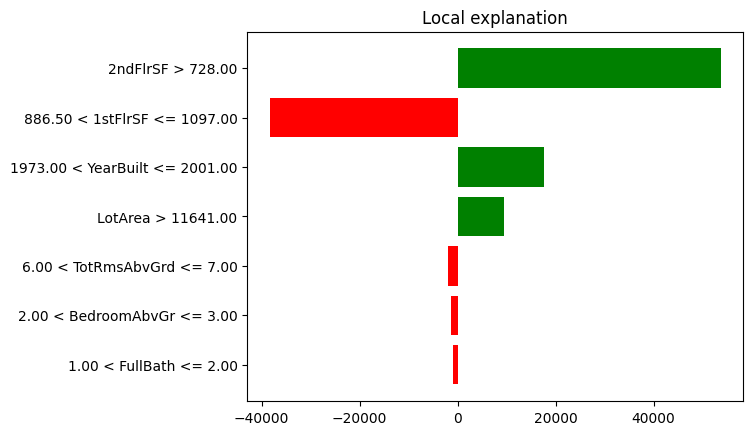

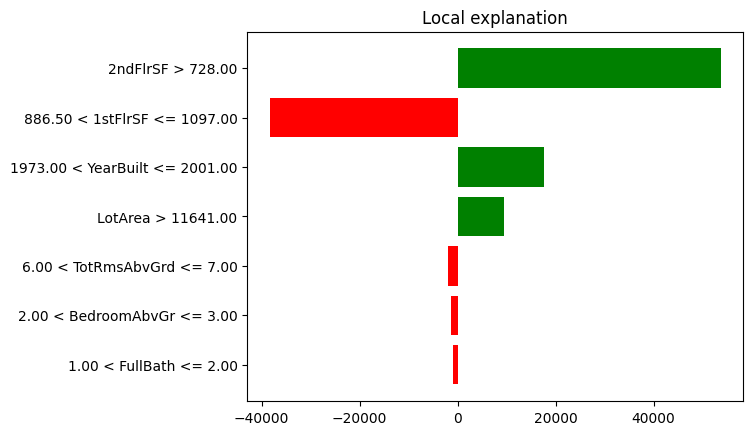

In [26]:


# Mostrar la explicación de la predicción
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()


# Usando SHAP (SHapley Additive exPlanations)
SHAP calcula los valores de Shapley para cada característica, 
los cuales indican la contribución de cada característica a la predicción, 
comparándola con el valor promedio del modelo. 
Esto da una visión precisa y matemática de cómo cada característica afecta el resultado.


In [22]:
explainer = shap.TreeExplainer(iowa_model)


In [24]:
shap_values = explainer.shap_values(val_X)


## Visualizacion de una prediccion específica (muestra individual)
Puedes visualizar cómo cada característica afectó una predicción específica en el conjunto de validación. Por ejemplo, si quieres analizar la primera muestra:

In [25]:
i = 0  # Cambia el índice para ver otras predicciones

# Mostrar explicación para una predicción individual
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], val_X.iloc[i])


Este gráfico de force plot te mostrará cómo cada característica afectó la predicción, ya sea empujando el valor hacia arriba o hacia abajo en comparación con el valor esperado del modelo.

## Visualización de resumen (global)
Para tener una vista más general de cómo las características afectan las predicciones en todo el conjunto de validación, puedes usar un gráfico resumen. Este gráfico muestra la importancia de cada característica y cómo influye en las predicciones (si afecta positiva o negativamente).

### Este gráfico te muestra:

* La importancia de las características (ordenadas de mayor a menor).
* Cómo varía el valor SHAP para cada característica: puntos a la izquierda indican que la característica disminuye la predicción, y puntos a la derecha indican que aumenta la predicción.

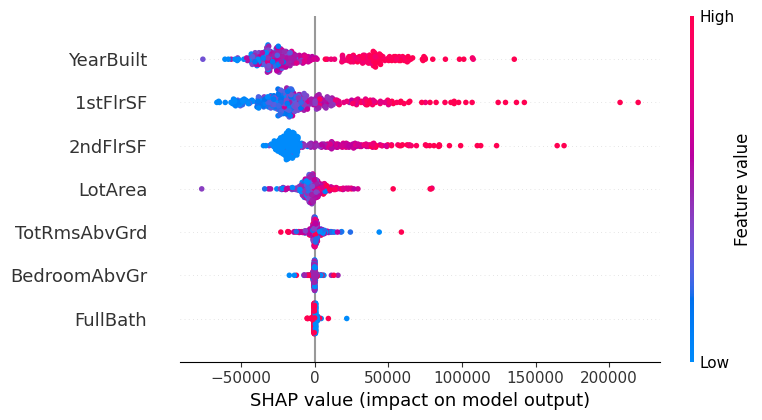

In [27]:
shap.summary_plot(shap_values, val_X)


## Gráfico de dependencia (para una característica específica)
Este gráfico te permite ver cómo una característica específica influye en las predicciones. Por ejemplo, si quieres ver cómo LotArea afecta a las predicciones:

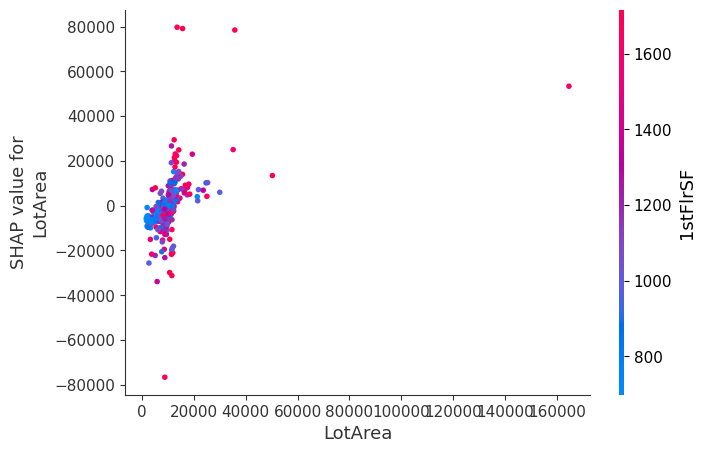

In [29]:
shap.dependence_plot('LotArea', shap_values, val_X)


In [30]:
# para hacer el gradiente de color en funcion de otra caracteristica: 

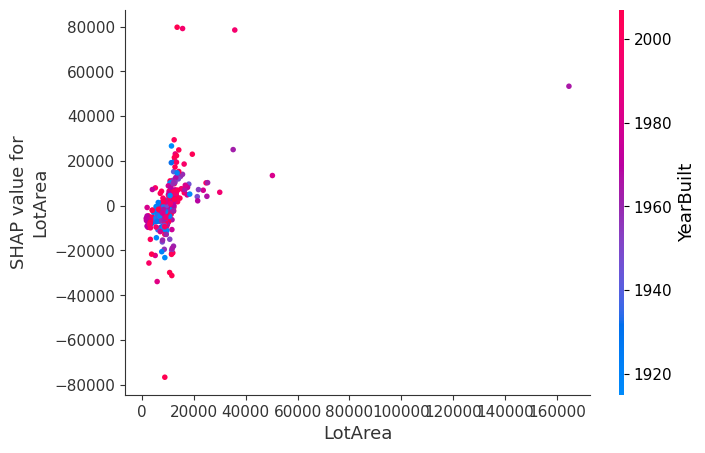

In [31]:
shap.dependence_plot('LotArea', shap_values, val_X, interaction_index='YearBuilt')


In [34]:

#Automatizar la búsqueda de correlaciones: 
#Si no tienes claro qué variable puede estar más correlacionada con LotArea,las calculo con pandas:

correlations = val_X.corr()
print(correlations['LotArea'].sort_values(ascending=False))

LotArea         1.000000
1stFlrSF        0.257363
TotRmsAbvGrd    0.136211
FullBath        0.097050
BedroomAbvGr    0.062578
2ndFlrSF        0.038174
YearBuilt       0.033908
Name: LotArea, dtype: float64
